## Microlensing within SLSim
### Author: [Paras Sharma](https://github.com/timedilatesme)

### For running on Seawulf cluster
```bash
module load slurm
srun -J [job_name] -N 1 -p a100 --gpus=1 --pty bash
module load cuda120/toolkit/12.0
jupyter notebook --ip=0.0.0.0 --no-browser --port=8888
```
Then from jupyter notebook, under `Kernel` $\Rightarrow$ `Select Another kernel` $\Rightarrow$ `Existing Jupyter Server` $\Rightarrow$ `Enter the URL of the running Jupyter server`. Copy the URL from the terminal where you started the jupyter notebook and paste it here.

In [ ]:
from slsim.Microlensing.magmap import MagnificationMap
from slsim.Microlensing.lightcurve import MicrolensingLightCurve
from matplotlib import pyplot as plt
import numpy as np
from slsim.Microlensing.lightcurvelensmodel import MicrolensingLightCurveFromLensModel
from slsim.Util.astro_util import theta_star_physical
from slsim.Plots.plot_functions import (
    plot_lightcurves_and_magmap,
    plot_magnification_map,
)

# might not need all of these
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop

# from astropy import constants as const
from astropy import units as u

import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.QuasarCatalog.quasar_pop import QuasarRate

### 1. Microlensing Map Generation

Generating magnification map ...
Done generating magnification map.


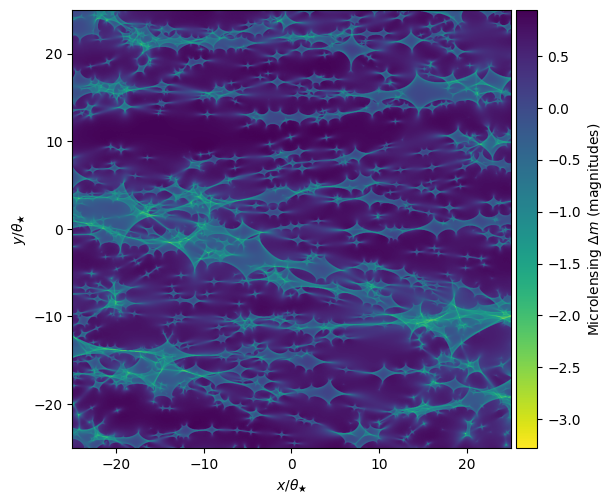

In [ ]:
kwargs_MagnificationMap = {
    "kappa_tot": 0.34960889,
    "shear": 0.34860889,
    "kappa_star": 0.24,
    "theta_star": 4e-6,  # arcsec
    "center_x": 0,  # arcsec
    "center_y": 0,  # arcsec
    "half_length_x": 25 * 4e-6,  # arcsec
    "half_length_y": 25 * 4e-6,  # arcsec
    "mass_function": "kroupa",
    "m_solar": 1.0,
    "m_lower": 0.08,
    "m_upper": 100,
    "num_pixels_x": 1000,
    "num_pixels_y": 1000,
    "kwargs_IPM": {},
}
magmap = MagnificationMap(
    **kwargs_MagnificationMap,
)
plot_magnification_map(magmap, cmap="viridis_r", origin="lower")

### 2. Light Curve Extraction Using a Microlensing Map

#### 2.1 Gaussian Source

Generating magnification map ...
Done generating magnification map.


Text(0.5, 0.98, 'Point Source Microlensing Lightcurves')

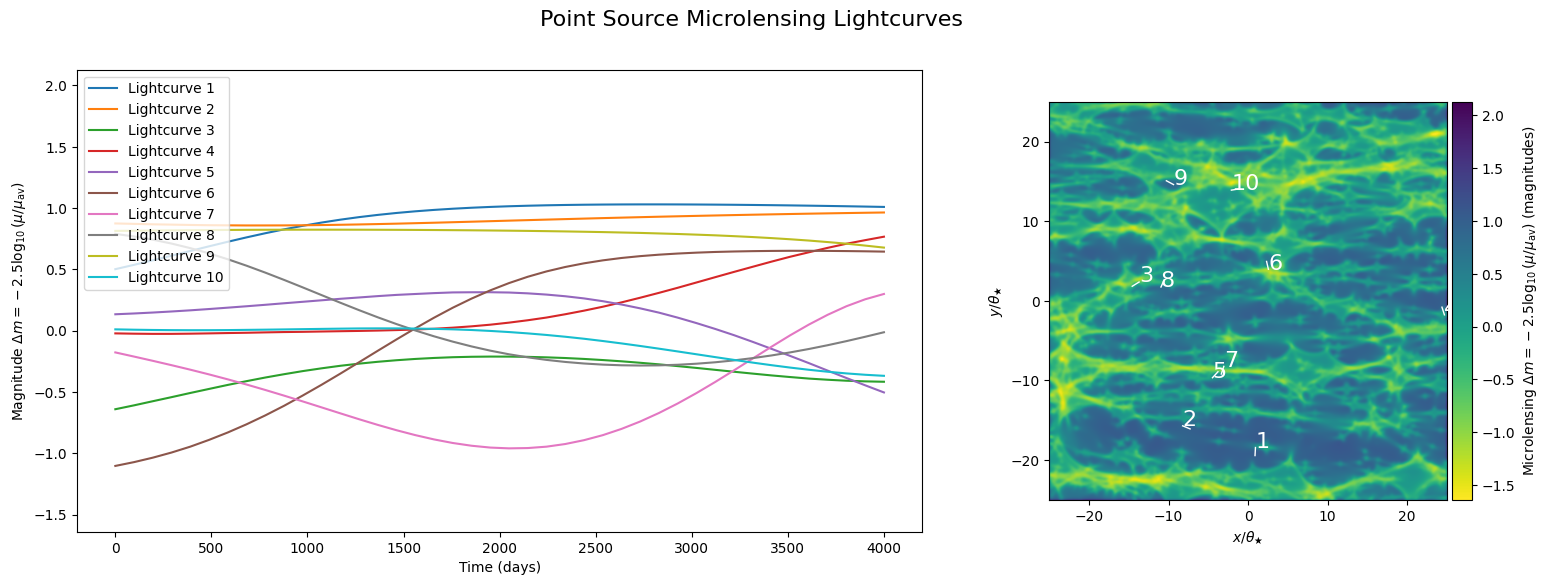

In [ ]:
source_redshift = 2.467248566851947
deflector_redshift = 0.6688619611721243
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

theta_star, _, _ = theta_star_physical(
    z_lens=deflector_redshift,
    z_src=source_redshift,
    m=1,
    cosmo=cosmo,
)
theta_star = theta_star.to(u.arcsec).value

kwargs_MagnificationMap = {
    "kappa_tot": 0.37405285,
    "shear": 0.37623754,
    "kappa_star": 0.24271499,
    "theta_star": theta_star,  # arcsec
    "center_x": 0,  # arcsec
    "center_y": 0,  # arcsec
    "half_length_x": 25 * theta_star,  # arcsec
    "half_length_y": 25 * theta_star,  # arcsec
    "mass_function": "kroupa",
    "m_solar": 1.0,
    "m_lower": 0.08,
    "m_upper": 100,
    "num_pixels_x": 2000,
    "num_pixels_y": 2000,
}

magmap = MagnificationMap(
    **kwargs_MagnificationMap,
)


kwargs_gaussian_source_morphology = {
    "source_redshift": 0.5,
    "cosmo": cosmo,
    "source_size": 8e-7,  # arcsec, this is the size of typical AGN Disk
}

ml_lc = MicrolensingLightCurve(
    magmap,
    time_duration=4000,
    point_source_morphology="gaussian",
    kwargs_source_morphology=kwargs_gaussian_source_morphology,
)

LCs, tracks, _ = ml_lc.generate_lightcurves(
    source_redshift=0.5,
    cosmo=cosmo,
    lightcurve_type="magnitude",
    effective_transverse_velocity=1000,  # km/s
    num_lightcurves=10,
)


ax = plot_lightcurves_and_magmap(
    convolved_map=ml_lc._convolved_map,
    lightcurves=LCs,
    tracks=tracks,
    magmap_instance=magmap,
    lightcurve_type="magnitude",
)

ax[0].figure.suptitle(
    "Gaussian Source Microlensing Lightcurves",
    fontsize=16,
)

#### 2.2 AGN Disk

Generating magnification map ...
Done generating magnification map.


Text(0.5, 0.98, 'AGN Source Microlensing Lightcurves')

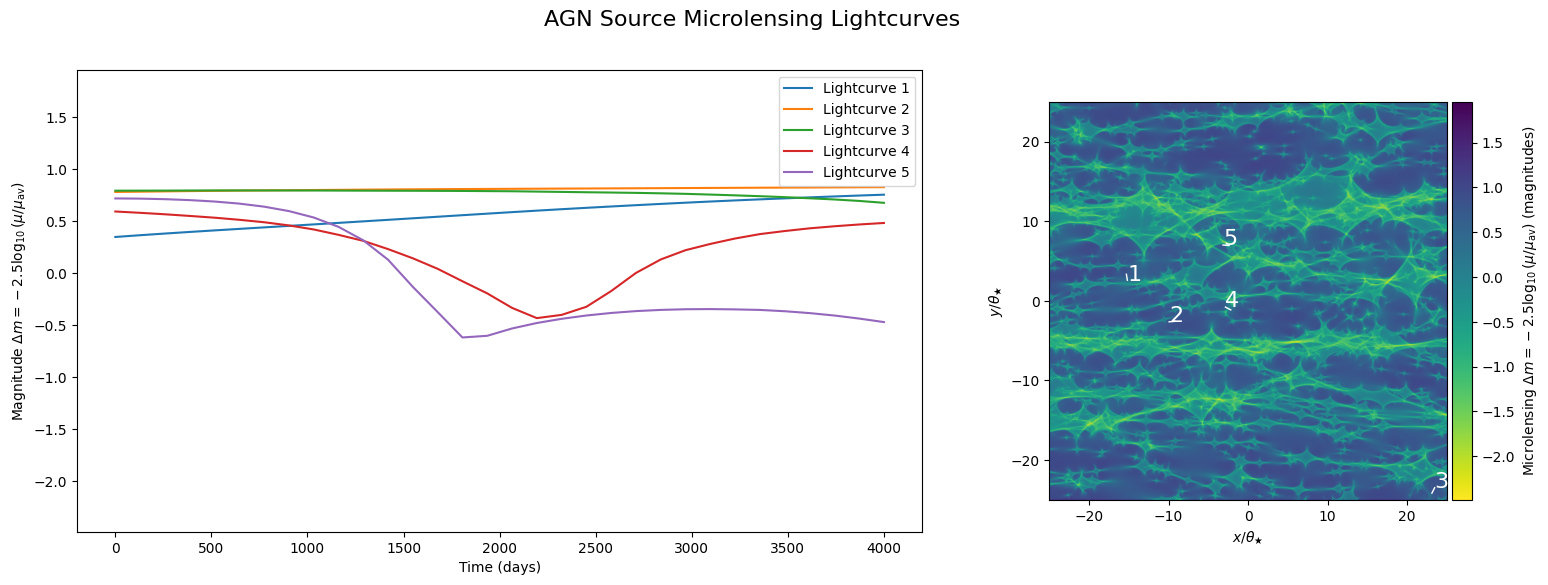

In [ ]:
source_redshift = 2.467248566851947
deflector_redshift = 0.6688619611721243
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

theta_star, _, _ = theta_star_physical(
    z_lens=deflector_redshift,
    z_src=source_redshift,
    m=1,
    cosmo=cosmo,
)
theta_star = theta_star.to(u.arcsec).value

kwargs_MagnificationMap = {
    "kappa_tot": 0.37405285,
    "shear": 0.37623754,
    "kappa_star": 0.24271499,
    "theta_star": theta_star,  # arcsec
    "center_x": 0,  # arcsec
    "center_y": 0,  # arcsec
    "half_length_x": 25 * theta_star,  # arcsec
    "half_length_y": 25 * theta_star,  # arcsec
    "mass_function": "kroupa",
    "m_solar": 1.0,
    "m_lower": 0.08,
    "m_upper": 100,
    "num_pixels_x": 2000,
    "num_pixels_y": 2000,
}

magmap = MagnificationMap(
    **kwargs_MagnificationMap,
)

kwargs_agn_source_morphology = {
    "source_redshift": 0.5,
    "cosmo": cosmo,
    "r_out": 1000,
    "r_resolution": 1000,
    "smbh_mass_exp": 8,
    "inclination_angle": 0,
    "black_hole_spin": 0,
    "observer_frame_wavelength_in_nm": 600,
    "eddington_ratio": 0.1,
}

ml_lc = MicrolensingLightCurve(
    magmap,
    time_duration=4000,
    point_source_morphology="agn",
    kwargs_source_morphology=kwargs_agn_source_morphology,
)

LCs, tracks, _ = ml_lc.generate_lightcurves(
    source_redshift=source_redshift,
    cosmo=cosmo,
    lightcurve_type="magnitude",
    effective_transverse_velocity=1000,  # km/s
    num_lightcurves=5,
)

ax = plot_lightcurves_and_magmap(
    convolved_map=ml_lc._convolved_map,
    lightcurves=LCs,
    tracks=tracks,
    magmap_instance=magmap,
    lightcurve_type="magnitude",
)
ax[0].figure.suptitle(
    "AGN Source Microlensing Lightcurves",
    fontsize=16,
)

### 3. Light Curve Extraction for images of point sources in the Lens Class

In [2]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
galaxy_sky_area = Quantity(value=1, unit="deg2")
quasar_sky_area = Quantity(value=1, unit="deg2")
full_sky_area = Quantity(value=5, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "i", "band_max": 26, "z_min": 0.001, "z_max": 5.0}

# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None, sky_area=galaxy_sky_area, filters=None, cosmo=cosmo
)

# Initiate deflector population class
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=galaxy_sky_area,
)

# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 5.01, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)
quasar_source = quasar_class.quasar_sample(m_min=15, m_max=30)

# Prepare dictionary of agn variability kwargs
variable_agn_kwarg_dict = {
    "length_of_light_curve": 500,
    "time_resolution": 1,
    "log_breakpoint_frequency": 1 / 20,
    "low_frequency_slope": 1,
    "high_frequency_slope": 3,
    "standard_deviation": 0.9,
}

kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "i", "r"},
    "agn_driving_variability_model": "bending_power_law",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, 1000, 500),
}
# Initiate source population class.
source_quasar = sources.PointSources(
    quasar_source,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    pointsource_type="quasar",
    **kwargs_quasar
)

# Initiate LensPop class to generate lensed quasar pop.
quasar_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

kwargs_lens_cuts = {}
# drawing population
quasar_lens_population = quasar_lens_pop.draw_population(
    speed_factor=1000, kwargs_lens_cuts=kwargs_lens_cuts
)

/gpfs/home/passharma/repos/self/slsim/slsim/Deflectors/all_lens_galaxies.py:54: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/gpfs/home/passharma/repos/self/slsim/slsim/Deflectors/all_lens_galaxies.py:57: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


In [3]:
# Select a random lens
kwargs_lens_cut = {"min_image_separation": 2, "max_image_separation": 10}
rgb_band_list = ["i", "r", "g"]
lens_class = quasar_lens_pop.select_lens_at_random(**kwargs_lens_cut)

In [5]:
band = "i"
source = lens_class.source(0)
source_redshift = source.redshift
kappa_star_images, kappa_tot_images, shear_images, shear_angle_images = (
    lens_class._microlensing_parameters_for_image_positions_single_source(
        band=band, source=source
    )
)

# Einstein radius of a unit mass point lens in arcsec units.
theta_star, _, _ = theta_star_physical(
    z_lens=lens_class.deflector_redshift,
    z_src=lens_class.source_redshift_list[0],
    m=1,
    cosmo=cosmo,
)
theta_star = theta_star.to(u.arcsec).value
print("theta_star", theta_star, "arcsec")

theta_star 1.8452457708660615e-06 arcsec


In [6]:
print("kappa_star_images: ", kappa_star_images)
print("kappa_tot_images:  ", kappa_tot_images)
print("shear_images:      ", shear_images)
print("theta_star:       ", theta_star, "arcsec")
print("deflector_redshift: ", lens_class.deflector_redshift)
print("source_redshift:    ", lens_class.source_redshift_list[0])

kappa_star_images:  [0.14684573 0.13928234 0.23187249 0.40110831]
kappa_tot_images:   [0.37771049 0.40476621 0.54454787 0.68446031]
shear_images:       [0.38031955 0.46158706 0.60417066 0.71743317]
theta_star:        1.8452457708660615e-06 arcsec
deflector_redshift:  0.7153033823364616
source_redshift:     3.428627403619874


In [ ]:
# kappa_star_images = [0.03093524, 0.04444799, 0.07865058, 0.11272447]
# kappa_tot_images = [0.61857161, 0.64814449, 0.75618223, 0.81452105]
# shear_images = [0.20892196, 0.24533288, 0.37750113, 0.43208388]
# theta_star = 2.1890576570033966e-06  # arcsec
# deflector_redshift = 0.4819360461686953
# source_redshift = 3.3633548069368993
# cosmology = FlatLambdaCDM(H0=70, Om0=0.3)  # for testing

#### 2.1 Gaussian Source

In [ ]:
cosmology = lens_class.cosmo
kwargs_MagnificationMap = {
    "theta_star": theta_star,  # arcsec
    "center_x": 0,  # arcsec
    "center_y": 0,  # arcsec
    "half_length_x": 4 * theta_star,  # arcsec
    "half_length_y": 4 * theta_star,  # arcsec
    "mass_function": "kroupa",
    "m_solar": 1.0,
    "m_lower": 0.08,
    "m_upper": 100,
    "num_pixels_x": 1000,
    "num_pixels_y": 1000,
}
kwargs_gaussian_source_morphology = {
    "source_redshift": source_redshift,
    "cosmo": cosmology,
    "source_size": 8e-8,  # arcsec, this is the size of typical AGN Disk
}

ml_lc_lens = MicrolensingLightCurveFromLensModel()
LCs_lens = ml_lc_lens.generate_point_source_microlensing_magnitudes(
    time=np.linspace(0, 4000, 500),  # time in days
    source_redshift=source_redshift,
    deflector_redshift=lens_class.deflector_redshift,
    kappa_star_images=kappa_star_images,
    kappa_tot_images=kappa_tot_images,
    shear_images=shear_images,
    shear_phi_angle_images=shear_angle_images,
    ra_lens=lens_class.deflector_position[0],
    dec_lens=lens_class.deflector_position[1],
    deflector_velocity_dispersion=lens_class.deflector_velocity_dispersion(),
    cosmology=cosmology,
    kwargs_MagnificationMap=kwargs_MagnificationMap,
    point_source_morphology="gaussian",
    kwargs_source_morphology=kwargs_gaussian_source_morphology,
)

Generating magnification map ...
Done generating magnification map.
Generating magnification map ...
Done generating magnification map.
Generating magnification map ...
Done generating magnification map.
Generating magnification map ...
Done generating magnification map.


Text(0.5, 1.0, 'Microlensing Light Curves for Different Images of a Quasar (Gaussian Source)')

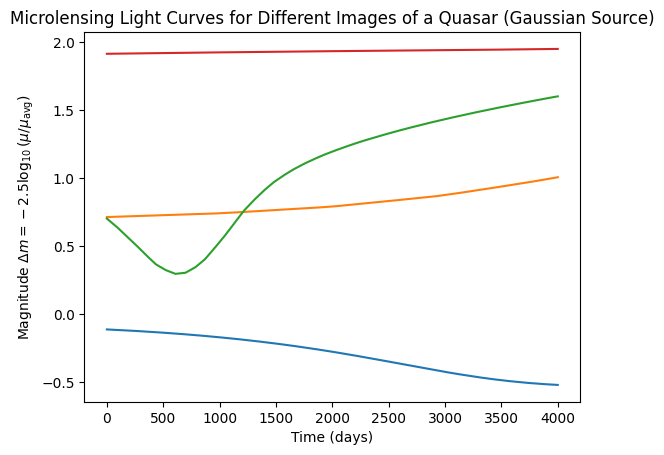

In [ ]:
# plot the light curves
for i in range(len(LCs_lens)):
    plt.plot(np.linspace(0, 4000, 500), LCs_lens[i], label=f"Image {i+1}")
plt.xlabel("Time (days)")
plt.ylabel("Magnitude $\Delta m = -2.5 \log_{10} (\mu/\mu_{\\text{avg}})$")
plt.title(
    "Microlensing Light Curves for Different Images of a Quasar (Gaussian Source)"
)

#### 2.2 AGN Disk

In [ ]:
cosmology = lens_class.cosmo
kwargs_MagnificationMap = {
    "theta_star": theta_star,  # arcsec
    "center_x": 0,  # arcsec
    "center_y": 0,  # arcsec
    "half_length_x": 4 * theta_star,  # arcsec
    "half_length_y": 4 * theta_star,  # arcsec
    "mass_function": "kroupa",
    "m_solar": 1.0,
    "m_lower": 0.08,
    "m_upper": 100,
    "num_pixels_x": 1000,
    "num_pixels_y": 1000,
}
kwargs_agn_source_morphology = {
    "source_redshift": source_redshift,
    "cosmo": cosmology,
    "r_out": 1000,
    "r_resolution": 1000,
    "smbh_mass_exp": 8,
    "inclination_angle": 0,
    "black_hole_spin": 0,
    "observer_frame_wavelength_in_nm": 600,
    "eddington_ratio": 0.1,
}

ml_lc_lens = MicrolensingLightCurveFromLensModel()
LCs_lens = ml_lc_lens.generate_point_source_microlensing_magnitudes(
    time=np.linspace(0, 4000, 500),  # time in days
    source_redshift=source_redshift,
    deflector_redshift=lens_class.deflector_redshift,
    kappa_star_images=kappa_star_images,
    kappa_tot_images=kappa_tot_images,
    shear_images=shear_images,
    shear_phi_angle_images=shear_angle_images,
    ra_lens=lens_class.deflector_position[0],
    dec_lens=lens_class.deflector_position[1],
    deflector_velocity_dispersion=lens_class.deflector_velocity_dispersion(),
    cosmology=cosmology,
    kwargs_MagnificationMap=kwargs_MagnificationMap,
    point_source_morphology="agn",
    kwargs_source_morphology=kwargs_agn_source_morphology,
)

Generating magnification map ...
Done generating magnification map.
Generating magnification map ...
Done generating magnification map.
Generating magnification map ...
Done generating magnification map.
Generating magnification map ...
Done generating magnification map.


Text(0.5, 1.0, 'Microlensing Light Curves for Different Images of a Quasar (AGN Source)')

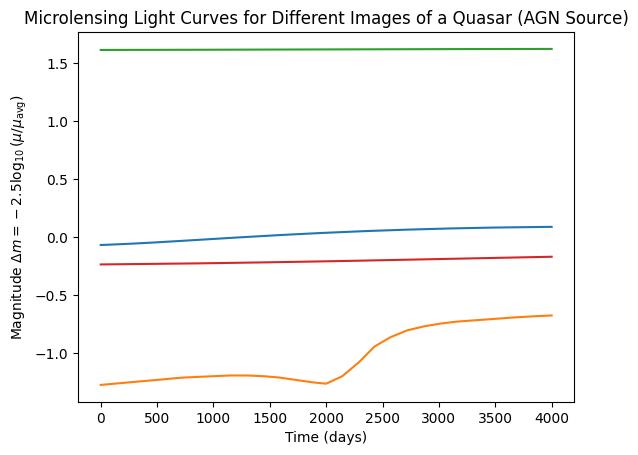

In [ ]:
# plot the light curves
for i in range(len(LCs_lens)):
    plt.plot(np.linspace(0, 4000, 500), LCs_lens[i], label=f"Image {i+1}")
plt.xlabel("Time (days)")
plt.ylabel("Magnitude $\Delta m = -2.5 \log_{10} (\mu/\mu_{\\text{avg}})$")
plt.title("Microlensing Light Curves for Different Images of a Quasar (AGN Source)")

In [ ]:
# visualize the light curves for the images

# figure layout
# image rgb with 1, 2, 3 ... label to quasars | microlensing light curves
# num_images panels => for magnification maps and tracks

# use gridspec for subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

## EXTRA: Smaller Size Magnification Maps

Generating magnification map ...
Done generating magnification map.


Text(0.5, 0.98, 'Point Source Microlensing Lightcurves')

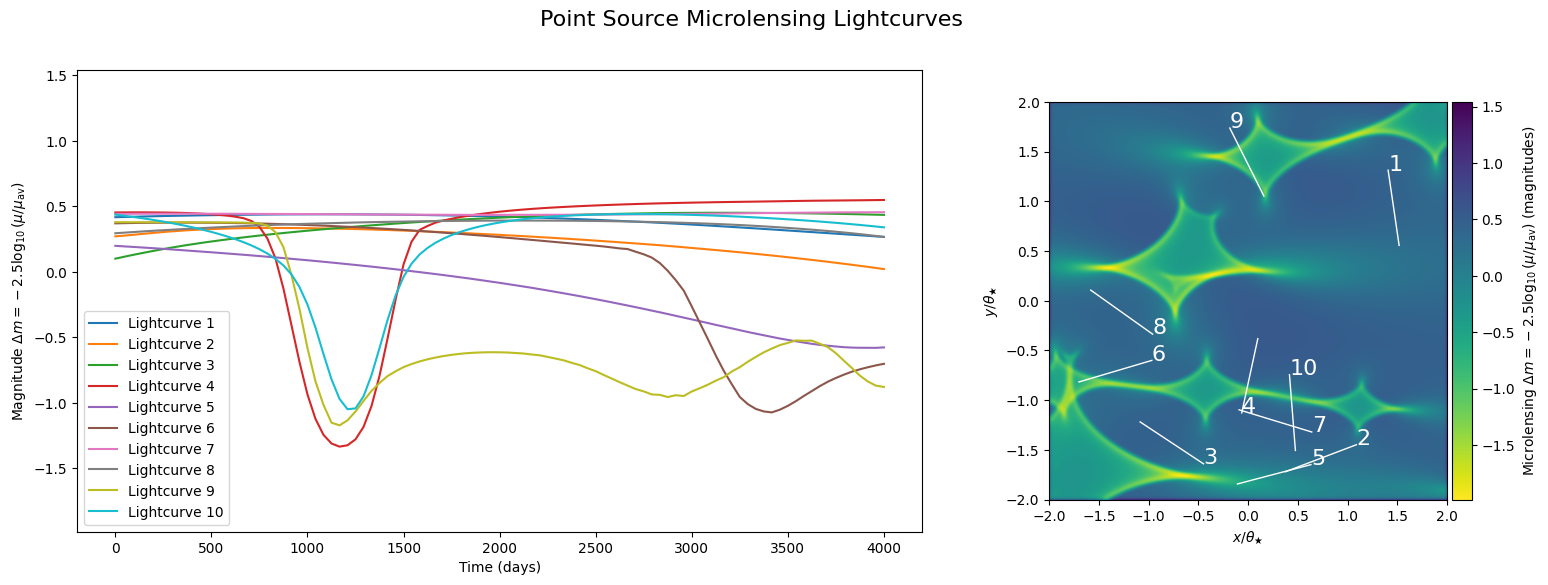

In [ ]:
source_redshift = 2.467248566851947
deflector_redshift = 0.6688619611721243
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

theta_star, _, _ = theta_star_physical(
    z_lens=deflector_redshift,
    z_src=source_redshift,
    m=1,
    cosmo=cosmo,
)
theta_star = theta_star.to(u.arcsec).value

kwargs_MagnificationMap = {
    "kappa_tot": 0.37405285,
    "shear": 0.37623754,
    "kappa_star": 0.24271499,
    "theta_star": theta_star,  # arcsec
    "center_x": 0,  # arcsec
    "center_y": 0,  # arcsec
    "half_length_x": 2 * theta_star,  # arcsec
    "half_length_y": 2 * theta_star,  # arcsec
    "mass_function": "kroupa",
    "m_solar": 1.0,
    "m_lower": 0.08,
    "m_upper": 100,
    "num_pixels_x": 500,
    "num_pixels_y": 500,
}

magmap = MagnificationMap(
    **kwargs_MagnificationMap,
)


kwargs_gaussian_source_morphology = {
    "source_redshift": source_redshift,
    "cosmo": cosmo,
    "source_size": 8e-8,  # arcsec, this is the size of typical AGN Disk
}

ml_lc = MicrolensingLightCurve(
    magmap,
    time_duration=4000,
    point_source_morphology="gaussian",
    kwargs_source_morphology=kwargs_gaussian_source_morphology,
)

LCs, tracks, _ = ml_lc.generate_lightcurves(
    source_redshift=source_redshift,
    cosmo=cosmo,
    lightcurve_type="magnitude",
    effective_transverse_velocity=1000,  # km/s
    num_lightcurves=10,
)


ax = plot_lightcurves_and_magmap(
    convolved_map=ml_lc._convolved_map,
    lightcurves=LCs,
    tracks=tracks,
    magmap_instance=magmap,
    lightcurve_type="magnitude",
)

ax[0].figure.suptitle(
    "Point Source Microlensing Lightcurves",
    fontsize=16,
)

Generating magnification map ...
Done generating magnification map.


Text(0.5, 0.98, 'AGN Source Microlensing Lightcurves')

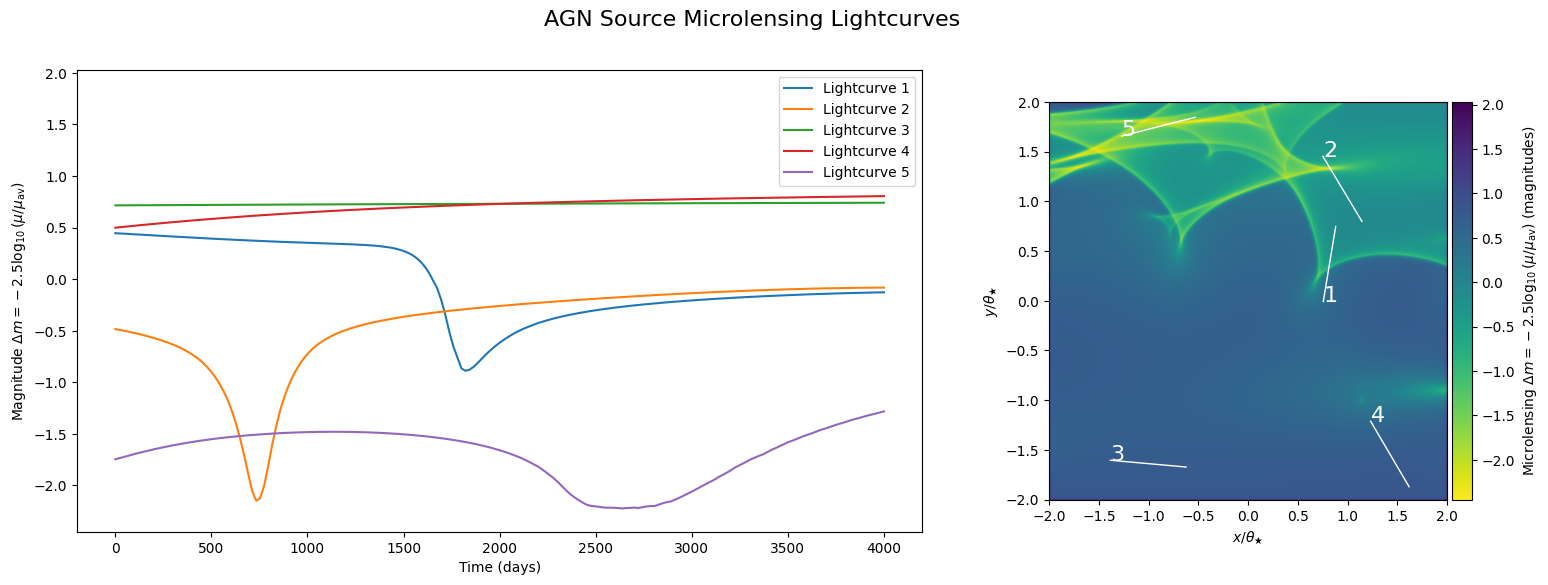

In [ ]:
source_redshift = 2.467248566851947
deflector_redshift = 0.6688619611721243
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

theta_star, _, _ = theta_star_physical(
    z_lens=deflector_redshift,
    z_src=source_redshift,
    m=1,
    cosmo=cosmo,
)
theta_star = theta_star.to(u.arcsec).value

kwargs_MagnificationMap = {
    "kappa_tot": 0.37405285,
    "shear": 0.37623754,
    "kappa_star": 0.24271499,
    "theta_star": theta_star,  # arcsec
    "center_x": 0,  # arcsec
    "center_y": 0,  # arcsec
    "half_length_x": 2 * theta_star,  # arcsec
    "half_length_y": 2 * theta_star,  # arcsec
    "mass_function": "kroupa",
    "m_solar": 1.0,
    "m_lower": 0.08,
    "m_upper": 100,
    "num_pixels_x": 1000,
    "num_pixels_y": 1000,
}

magmap = MagnificationMap(
    **kwargs_MagnificationMap,
)

kwargs_agn_source_morphology = {
    "source_redshift": source_redshift,
    "cosmo": cosmo,
    "r_out": 1000,
    "r_resolution": 1000,
    "smbh_mass_exp": 8,
    "inclination_angle": 0,
    "black_hole_spin": 0,
    "observer_frame_wavelength_in_nm": 600,
    "eddington_ratio": 0.1,
}

ml_lc = MicrolensingLightCurve(
    magmap,
    time_duration=4000,
    point_source_morphology="agn",
    kwargs_source_morphology=kwargs_agn_source_morphology,
)

LCs, tracks, _ = ml_lc.generate_lightcurves(
    source_redshift=source_redshift,
    cosmo=cosmo,
    lightcurve_type="magnitude",
    effective_transverse_velocity=1000,  # km/s
    num_lightcurves=5,
)

ax = plot_lightcurves_and_magmap(
    convolved_map=ml_lc._convolved_map,
    lightcurves=LCs,
    tracks=tracks,
    magmap_instance=magmap,
    lightcurve_type="magnitude",
)
ax[0].figure.suptitle(
    "AGN Source Microlensing Lightcurves",
    fontsize=16,
)